In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.misc import derivative
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
from multiprocessing import Pool, Value
from itertools import product
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
import nbimporter
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes_pump_probe, solve_mbes
#matplotlib.pyplot.switch_backend('nbAgg')
#%qtconsole

Importing Jupyter notebook from _create_pdf.ipynb
Importing Jupyter notebook from _helper_functions.ipynb
Importing Jupyter notebook from _steady_state.ipynb
Importing Jupyter notebook from _mbes.ipynb
Importing Jupyter notebook from _do_calculation.ipynb


In [2]:
gcoll = 45.18409188666773
q = 1.0058294512857613
quali = 1200
fr = 3092;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi #detuning cavity to spin central frequency ws-wc
deltac = 0*2*np.pi #detuning drive to cavity wc-wp
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 116.7755270154724
nbins = 1701#701#5000#20
g_number = 1 #how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

8.0948370707497


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund
    
    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002)*(1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse

def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)
    
    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004)*(1-logistic.cdf(t, loc=tend-0.02, scale=0.004))
    
    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq


In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)

x_start = 5
x_stop = 20 #µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

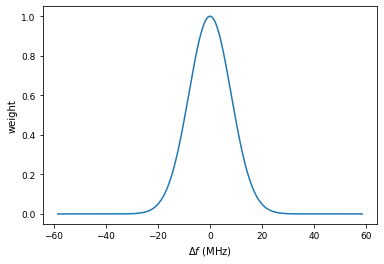

In [5]:
spins, gs, pdf = create_spins_inhomo_g(gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

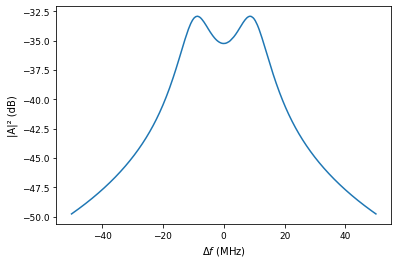

In [6]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [7]:
pumptime = 200e-3#5*np.pi/gcoll
decaytime = 500e-3
intertime = 10000e-3
probetime = 20e-3
dt = 4e-3 #The time resolution of the AWG. Don't change that because the solution of the MBEs are written in a way that use that as time resolution
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0

### Calibrate power

In [8]:
pulsei = np.ones((len(tlist)))

pin = np.arange(-15, 0,0.5)
aref = 150

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

<ipython-input-9-0993edfcf8c6>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolor(tplot, pin, alos, vmin=0, vmax=60)
<ipython-input-9-0993edfcf8c6>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolor(tplot, pin, szlos)


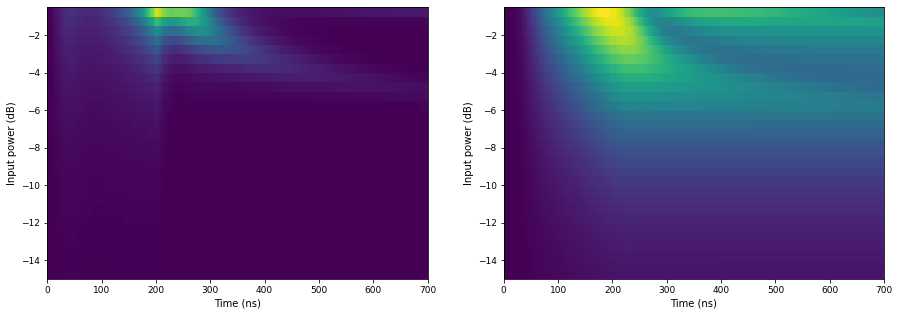

In [9]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.pcolor(tplot, pin, alos, vmin=0, vmax=60)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');


### Linear Rabi oscillations

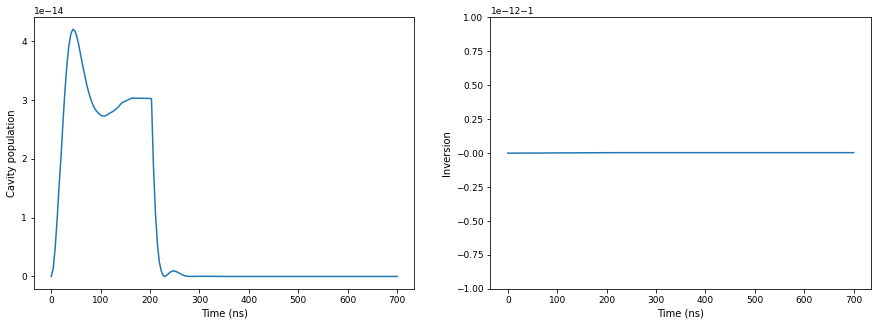

In [10]:
alos = np.zeros((len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))

asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, 0.00001, kappa, deltac, gs, gperp, spins, gpar)
alos = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
szlos = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
                  
                  
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(tplot, alos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Cavity population');

ax2.plot(tplot, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion');

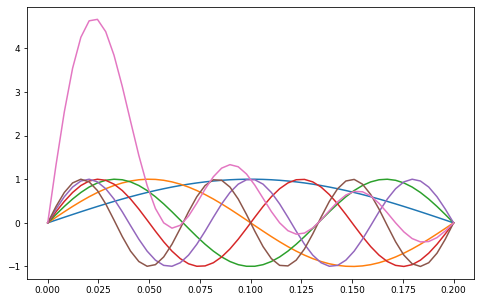

In [11]:
number_fcp = 6
ttest = np.linspace(0,pumptime,numsteps)
wgrund = np.pi/ttest[-1]
sumsin = np.zeros((number_fcp, len(ttest)))

fig, ax = plt.subplots(1,1, figsize=(8,5))

for i in range(number_fcp):
    sumsin[i, :] = np.sin(wgrund*ttest*(i+1))
    ax.plot(ttest, sumsin[i,:])
ax.plot(ttest, np.sum(sumsin, axis=0))
maxfourier = max(np.sum(sumsin, axis=0))

In [16]:
ampl = 150
pumpt = 0.72

class GRAPE:
    
    def __init__(self):
        self.tp = np.arange(0,pumpt+dt,dt)
        self.td = np.arange(0, decaytime+dt, dt)
        self.ti = np.arange(0, intertime+dt, dt)
        self.tpr = np.arange(0, probetime+dt, dt)
        self.number_fcp = number_fcp
        self.max_ampl = ampl
        self.max_t_ampl = 170
        self.target_time_decay = 1.9 #when after switching off the pulse the inversion should be maximum
        self.wgrund = np.pi/self.tp[-1]
        self.plot_handle = None
        self.counter = 0
        self.solution = None
        self.fcomps = None
        self.thres = 10 #points at beginning and end of pulses that should not be altered
        self.fitness = 0
        self.vars = []
        self.fig = None
        self.disp1 = display(Markdown(""), display_id='0')
        self.disp2 = display(Markdown(""), display_id='1')
        self.best_fitness = 1.
        self.epsilon = -5
        self.epsilon2 = 1
        self.target_fitness = 0.1
        self.dummy_fitness = []
        self.dummy_solution = []
        self.grad_idx = -1
        self.pulse = None
        self.gradients = np.zeros((2,len(self.tp)))
        self.maxcav = 0
        self.ampl_probe = 1e-3
        
    def fitness_func(self, x, *args):
        tidx = args[0]
        ichan = args[1]
        pulse = args[2][:]
        
        init = np.ones(nbins*2+1)*(-1)
        init[0] = 0
        init[1::2] = 0
        
        
        pi = pulse[:]
        pi[ichan][tidx] = x

        pulsei = pi[0]
        pulseq = pi[1]

        fitness, solution = self.calculate_fitness(pulsei, pulseq)
        
        self.dummy_fitness.append(fitness)
        self.dummy_solution.append(solution)
        return fitness
    
        
    def adjust_gradient(self, t, pulsei, pulseq):
        self.gradients = np.zeros((2, len(t)))
        tl = np.arange(len(t))
        #random.shuffle(tl)
        pn = np.array([pulsei.copy(), pulseq.copy()])
        pulse = np.array([pulsei.copy(), pulseq.copy()])
        ctr2 = 0
        for j in range(2):
            for i in tl:
                if i < self.thres or i > (len(t)-1-self.thres): 
                    ctr2 += 1
                    continue
                k = pn[j][i].copy()
                gra = scipy.misc.derivative(self.fitness_func, k, dx=abs(self.epsilon2), args=((i, j, pn.copy())))
                self.gradients[j][i] = gra
                self.grad_idx = i
                self.plot_stuff(self.fitness, self.solution, self.gradients)
                self.disp2.update(Markdown("### Current value: %i of %d; Current fitness: %f; Gradient: %f" %(ctr2, 2*len(self.tp), 1-self.dummy_fitness[1], gra)))
                self.dummy_fitness = []
                self.dummy_solution = []
                ctr2 += 1
                if i == len(pulsei)-1: ctr2 = 0
            
        for j in range(2):
            for i in tl:
                pn[j][i] = pulse[j][i] + self.epsilon*self.gradients[j][i]
        return pn[0], pn[1]
        
        
        
    def main(self, initial=None):
        t = datetime.datetime.now()
        self.filename_save = "/home/andreas/Physics/nelder_mead/grape_pump_probe_%s"%t.strftime("%Y-%m-%d %H:%M:%S")
        filename_save = self.filename_save
        if initial is None:
            self.pulsei, self.pulseq, spline = pulse_rwa_gauss_const(self.tp, (self.wgrund, np.random.uniform(-0, np.pi*2/self.number_fcp, (self.number_fcp)), self.max_ampl))
            init = spline[:]
        else:
            init = initial
            self.pulsei = init[0]
            self.pulseq = init[1]
        
        self.pulse = np.sqrt(self.pulsei**2+self.pulseq**2)
        while self.best_fitness > self.target_fitness:
            self.fitness, self.solution = self.calculate_fitness(self.pulsei, self.pulseq)
            self.plot_stuff(self.fitness, self.solution, self.gradients)
            self.pulsei, self.pulseq = self.adjust_gradient(self.tp, self.pulsei.copy(), self.pulseq.copy())
            self.counter += 1
            
            if self.fitness < self.best_fitness:
                savedict = {'wgrund': self.wgrund, 'time': self.tp, 'timedecay': self.td, 'pulse':np.vstack((self.pulsei, self.pulseq)), 'solution': self.solution, 'fitness': self.fitness, 'nbins':nbins, 'gammaq':gammaq,'gpar': gpar, 'gperp':gperp, 'deltac': deltac, 'delta':delta, 'kappa':kappa,'gs':gs, 'spline': self.pulse, 'gradients':self.gradients}
            
                pulseforsave = np.zeros((len(self.tp), 3))
                pulseforsave[:,0] = self.tp
                pulseforsave[:,1] = self.pulsei
                pulseforsave[:,2] = self.pulseq
                savedict2 = {'wgrund': self.wgrund, 'puls': pulseforsave}
                if self.fitness < 0.5:
                    scipy.io.savemat(self.filename_save, savedict)
                    scipy.io.savemat(self.filename_save + '_simple', savedict2)
                self.best_fitness = self.fitness
            
        
    
   
    def plot_stuff(self, fitness, solution, gradients):
        if not self.fig:
            self.fig, ((ax1, ax2), (ax3, ax0)) = plt.subplots(2,2,figsize=(15,10))
        else:
            ax1, ax2, ax3, ax0 = self.fig.axes
            ax1.clear()
            ax2.clear()
            ax3.clear()
            ax0.clear()
            gc.collect()
        pos0 = ax0.get_position()
        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        pos3 = ax3.get_position()
        pos1n = [(pos2.x0+pos3.x0)/2, pos1.y0,  pos1.width, pos1.height] 
        
        
        ax1.plot(self.tp*1000, self.pulsei, 'b-')
        ax1.plot(self.tp*1000, self.pulseq, 'g-')
        
        szsol = np.real(np.sum(self.solution[:, 2::2], axis=1))
        asol = self.solution[:,0]
        
        ax1.plot(self.tp*1000, np.sqrt(self.pulsei**2+self.pulseq**2), 'k--')
        ax1.set_ylabel("Amplitude (a.u.)")
        ax1.set_xlabel("Time (ns)")        
        ax1.set_ylim([-self.max_t_ampl-50, self.max_t_ampl+50])
        ax1.set_xlim([-20, 20+self.tp[-1]*1000])
        
        idxi = len(self.tp)
        idxpr = idxi +len(self.ti)
        idxdec = idxpr + len(self.tpr)
        
        tlp = self.tp*1000
        tli = self.ti*1000+tlp[-1]
        tlpr = self.tpr*1000+tli[-1]
        tld = self.td*1000+tlpr[-1]
        
        
        ax2.plot(tlp, szsol[:idxi], 'r-')
        ax2.plot(tli, szsol[idxi:idxpr], 'g-')
        ax2.plot(tlpr, szsol[idxpr:idxdec], 'm-')
        ax2.plot(tld, szsol[idxdec:], 'k-')
        ax2.set_ylabel("Inversion")
        ax2.set_xlabel("Time (ns)")
        ax2.set_ylim([-1,1])
        ax3.semilogy(tlp, abs(asol[:idxi])**2, 'b-')
        ax3.semilogy(tli, abs(asol[idxi:idxpr])**2, 'y-')
        ax3.semilogy(tlpr, abs(asol[idxpr:idxdec])**2, 'k-')
        ax3.semilogy(tld, abs(asol[idxdec:])**2, 'c-')
        ax3.set_ylabel("|A|²")
        ax3.set_xlabel("Time (ns)")
        
        ax0.plot(tlpr, abs(asol[idxpr:idxdec])**2, 'r-')
        ax0.plot(tld, abs(asol[idxdec:])**2, 'b-')
        ax0.set_ylabel("|A|²")
        ax0.set_xlabel("Time (ns)")
        if not self.plot_handle:
            self.plot_handle = display(self.fig, display_id='plot')
        else:
            self.plot_handle.update(self.fig)
        idx = np.abs(self.td - self.target_time_decay).argmin()
        self.disp1.update(Markdown("### Generation %i; Number of Photons: %f; Fitness: %f" %(self.counter, self.maxcav, self.fitness)))
        


            
    def calculate_fitness(self, pulsei, pulseq):

        init = np.ones(len(spins)*2+1)*(-1)
        init[0] = 0
        init[1::2] = 0
        val_add = 0
        solutionpump, solutioninter, solutionprobe, solutiondecay, infodict = solve_mbes_pump_probe(mbes_soc, init, pdf, self.tp, self.ti, self.tpr, self.td, self.ampl_probe, self.pulsei, self.pulseq, self.tp, kappa, deltac, gs, gperp, spins, gpar)

        max_p_ampl = max(np.sqrt(self.pulsei**2+self.pulseq**2))

        val_add = 0
        if max_p_ampl > self.max_t_ampl:
            val_add += max_p_ampl
        
        self.solution = np.vstack((solutionpump, solutioninter, solutionprobe, solutiondecay))
        self.maxcav = np.sum((abs(solutionprobe[:,0])**2))+np.sum((abs(solutiondecay[:,0])**2))
        self.fitness = self.maxcav
        return -self.maxcav+val_add, self.solution

### Generation 0; Number of Photons: 0.003533; Fitness: 0.003533

### Current value: 351 of 362; Current fitness: 1.003533; Gradient: 0.000000

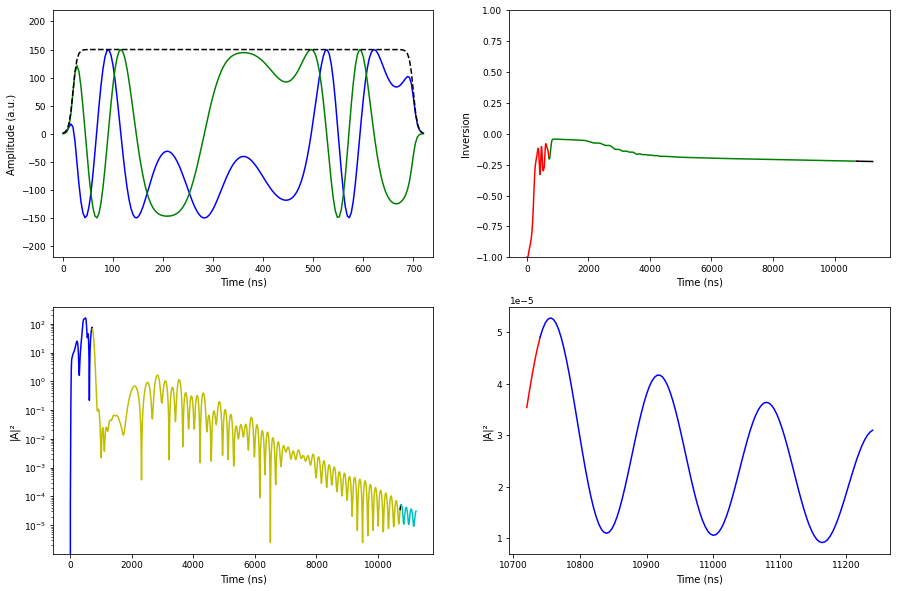

FileNotFoundError: [Errno 2] No such file or directory: '/home/andreas/Physik/nelder_mead/grape_2020-09-03 16:55:17.mat'

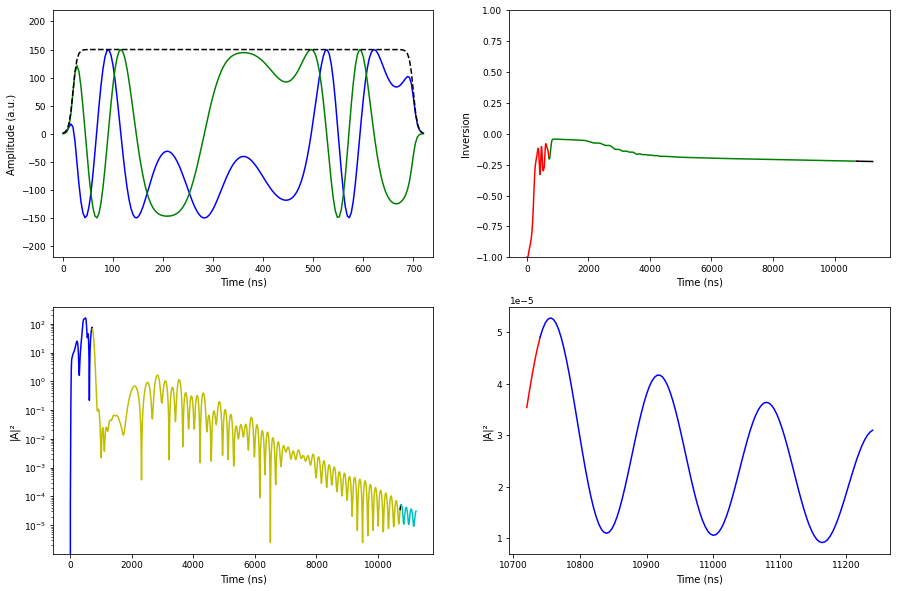

In [17]:
init = array([[   1.00392764,    2.59139917,    6.01240701,   11.85564721,
         17.28779228,   12.01116434,  -13.25830399,  -51.84247434,
        -90.42263689, -121.26271342, -141.33627509, -149.50561343,
       -145.5538105 , -130.06171519, -104.41378341,  -70.73437182,
        -31.73443581,    9.50895452,   49.81055787,   86.14262539,
        115.88048971,  137.00395517,  148.23600442,  149.10771305,
        139.94666672,  121.79459775,   96.26733196,   65.37553341,
         31.32753595,   -3.66445268,  -37.55607865,  -68.60639599,
        -95.46889987, -117.23570548, -133.43796453, -144.00981184,
       -149.22574976, -149.62233954, -145.91456389, -138.91561329,
       -129.46657601, -118.3800176 , -106.39908615,  -94.17183159,
        -82.2390139 ,  -71.03282137,  -60.88356862,  -52.0314896 ,
        -44.64105719,  -38.81573139,  -34.61156353,  -32.04859663,
        -31.11946012,  -31.79494478,  -34.02665926,  -37.74712253,
        -42.86784714,  -49.27612307,  -56.83132275,  -65.36160773,
        -74.66191406,  -84.49401461,  -94.58929046, -104.65459037,
       -114.38122917, -123.45680048, -131.57909972, -138.47112161,
       -143.89586461, -147.6695873 , -149.67224222, -149.85405977,
       -148.23763964, -144.91537632, -140.04253156, -133.82670077,
       -126.51474308, -118.37841785, -109.69998252, -100.75887042,
        -91.82031922,  -83.12650605,  -74.89041589,  -67.29236818,
        -60.47888563,  -54.56342757,  -49.62843124,  -45.72810194,
        -42.89145238,  -41.12519514,  -40.41622052,  -40.73352967,
        -42.02962366,  -44.24146172,  -47.29118752,  -51.08687222,
        -55.52353454,  -60.48466745,  -65.84443281,  -71.47058371,
        -77.22805291,  -82.98301818,  -88.60714046,  -93.98158462,
        -99.00039069, -103.57277258, -107.62398231, -111.09448474,
       -113.93732514, -116.11372694, -117.58711201, -118.31588408,
       -118.24545349, -117.30011577, -115.37553951, -112.33278467,
       -107.99496869, -102.14791881,  -94.54636307,  -84.92735589,
        -73.03260336,  -58.6410075 ,  -41.61192676,  -21.93820027,
          0.19417564,   24.34563966,   49.77102197,   75.38792384,
         99.77946165,  121.24504021,  137.90933852,  147.89233401,
        149.53210394,  141.63863503,  123.74354349,   96.3010375 ,
         60.79341357,   19.70265147,  -23.67118279,  -65.53649335,
       -102.04304458, -129.75668663, -146.09731516, -149.6639066 ,
       -140.38999248, -119.50533025,  -89.31693436,  -52.85587101,
        -13.45756131,   25.65131058,   61.69638797,   92.58823868,
        117.02856227,  134.49885022,  145.15790385,  149.68330228,
        149.09210139,  144.56992686,  137.32816737,  128.49897978,
        119.06931478,  109.84921352,  101.46639324,   94.37822105,
         88.89286923,   85.19299925,   83.35702594,   83.37409838,
         85.14808633,   88.47986327,   92.99758946,   97.95252982,
        101.69674722,  100.68562331,   89.20015717,   64.73098443,
         36.64217275,   16.92499602,    6.94059874,    2.68125005,
          1.00392764], [ 0.00000000e+00,  7.50656181e-01,  3.80240247e+00,  1.33848311e+01,
        3.64492211e+01,  7.40319656e+01,  1.08854338e+02,  1.21523399e+02,
        1.10635391e+02,  8.36256762e+01,  4.71581056e+01,  6.07791685e+00,
       -3.56806617e+01, -7.46248083e+01, -1.07667123e+02, -1.32267176e+02,
       -1.46602094e+02, -1.49697372e+02, -1.41487832e+02, -1.22798252e+02,
       -9.52454636e+01, -6.10729990e+01, -2.29365458e+01,  1.63367446e+01,
        5.39900937e+01,  8.75561298e+01,  1.15033042e+02,  1.35003850e+02,
        1.46692145e+02,  1.49955233e+02,  1.45222384e+02,  1.33391013e+02,
        1.15696539e+02,  9.35723750e+01,  6.85150321e+01,  4.19663448e+01,
        1.52208938e+01, -1.06374579e+01, -3.47698151e+01, -5.65902146e+01,
       -7.57522653e+01, -9.21204181e+01, -1.05731899e+02, -1.16754726e+02,
       -1.25446182e+02, -1.32114868e+02, -1.37088260e+02, -1.40686617e+02,
       -1.43203268e+02, -1.44890783e+02, -1.45952183e+02, -1.46536301e+02,
       -1.46736428e+02, -1.46591546e+02, -1.46089652e+02, -1.45172844e+02,
       -1.43744035e+02, -1.41675205e+02, -1.38817149e+02, -1.35010593e+02,
       -1.30098419e+02, -1.23938539e+02, -1.16416778e+02, -1.07458907e+02,
       -9.70408904e+01, -8.51963521e+01, -7.20204174e+01, -5.76693028e+01,
       -4.23554028e+01, -2.63380521e+01, -9.91059575e+00,  6.61519246e+00,
        2.29260157e+01,  3.87238132e+01,  5.37409467e+01,  6.77525952e+01,
        8.05854812e+01,  9.21224738e+01,  1.02303049e+02,  1.11119980e+02,
        1.18612938e+02,  1.24859857e+02,  1.29967017e+02,  1.34058708e+02,
        1.37267274e+02,  1.39724130e+02,  1.41552177e+02,  1.42859864e+02,
        1.43736994e+02,  1.44252273e+02,  1.44452515e+02,  1.44363359e+02,
        1.43991356e+02,  1.43327224e+02,  1.42350074e+02,  1.41032377e+02,
        1.39345388e+02,  1.37264726e+02,  1.34775779e+02,  1.31878564e+02,
        1.28591710e+02,  1.24955267e+02,  1.21032122e+02,  1.16907920e+02,
        1.12689497e+02,  1.08501985e+02,  1.04484824e+02,  1.00786981e+02,
        9.75617032e+01,  9.49610574e+01,  9.31303983e+01,  9.22027742e+01,
        9.22930806e+01,  9.34916191e+01,  9.58565850e+01,  9.94049571e+01,
        1.04101329e+02,  1.09844448e+02,  1.16451643e+02,  1.23642000e+02,
        1.31019994e+02,  1.38062422e+02,  1.44112621e+02,  1.48387046e+02,
        1.49999874e+02,  1.48011114e+02,  1.41502104e+02,  1.29679069e+02,
        1.12000264e+02,  8.83155718e+01,  5.90001216e+01,  2.50570857e+01,
       -1.18384919e+01, -4.93811408e+01, -8.47793338e+01, -1.15004827e+02,
       -1.37128264e+02, -1.48700388e+02, -1.48120475e+02, -1.34925787e+02,
       -1.09941880e+02, -7.52542509e+01, -3.39937421e+01,  1.00356894e+01,
        5.28266033e+01,  9.06558108e+01,  1.20509274e+02,  1.40378976e+02,
        1.49395094e+02,  1.47790427e+02,  1.36724379e+02,  1.18014482e+02,
        9.38313147e+01,  6.64082772e+01,  3.78045356e+01,  9.74212128e+00,
       -1.64786240e+01, -3.99941941e+01, -6.03404722e+01, -7.73822146e+01,
       -9.12276521e+01, -1.02142610e+02, -1.10473840e+02, -1.16586770e+02,
       -1.20819312e+02, -1.23450841e+02, -1.24683815e+02, -1.24634151e+02,
       -1.23324064e+02, -1.20665585e+02, -1.16409956e+02, -1.10014550e+02,
       -1.00370387e+02, -8.55452152e+01, -6.37838654e+01, -3.78800694e+01,
       -1.68749714e+01, -5.76667875e+00, -1.56057416e+00, -2.99553872e-01,
       -7.85336844e-16]])

gg = GRAPE()
gg.main(initial= init)